# LAMMPS Data Processing

In [19]:
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression

import nglview

In [20]:
def D_func(slope):
    # Slope in A2 /ps
    # Output in     cm2/s
    return (slope / 6) * 10**12 / (10**(8*2))

def N_eff_func(ave_msd, a):
    return max(ave_msd) * 420 / (a**2)

def sigma_func(D, N_mobile_ions, unit_cell_volume, T):
    return ( (D * (10**-2)**2) * (N_mobile_ions/(unit_cell_volume*(10**-10)**3)) * ((1.6e-19)**2) / (1.38e-23*T) ) * (10**3/10**2)

print(sigma_func(1.9e-9, 448, 25.98808**3, 298))

def E_a_func(slope):
    return -slope*(8.62*10**-5)*np.log(10)

0.3018934182241417


In [21]:
a = 2.4 # Approx. site hopping length, for use in N_Eff
record_freq = 10
diffusivity_columns = ['Doping Element', 'Doping Concentration (Formulaic)', 'Configuration', 'Temperature (K)', 'Run Number', 
           'Diffusivity (cm^2/s)', 'Conductivity (mS/cm)', 'Correlation Factor',  'N Eff (>500)']
diffusivity_df = pd.DataFrame(columns=diffusivity_columns)
for element in ['Al']:
    for concentration in np.arange(0, 0.351, 0.05):
        for (T, unit_cell_volume, dt) in [(300, 25.98808**3, 0.004), (600, 26.08711**3, 0.004), (900, 26.18614**3, 0.001), (1200, 26.28517**3, 0.001), (1500, 26.38420**3, 0.001)]:
            for config in [0, 1, 2, 3]:

                linearModel = LinearRegression()

                # MSD / MSCD
                for i,msd_file in enumerate(glob.glob('data/LLZO_Ia3d_%s%02.f_%.0f/msd*-%.0f.out' % (element, 100*concentration, config, T))):
                    df = pd.read_csv(msd_file, sep=" ", low_memory=False)
                    pos = np.array(df['Time-averaged'])
                    msd = pos[6::5].astype('float64')
                    time = dt*record_freq*np.array(range(msd.shape[0]))
                    if len(time) < 2*int(10/(dt*record_freq)):
                        print(r'%0.2f %d' % (concentration, T))
                        continue

                    linearModel.fit(time[int(10/(dt*record_freq)):].reshape(-1,1), msd[int(10/(dt*record_freq)):])
                    D = D_func(linearModel.coef_[0])

                    N_eff = N_eff_func(msd, a)

                    mscd_file = 'data/LLZO_Ia3d_%s%02.f_%.0f/mscd%.0f-%.0f.out' % (element, 100*concentration, config, i, T)
                    try:
                        df = pd.read_csv(mscd_file, sep=" ", low_memory=False)
                        pos = np.array(df['Time-averaged'])
                        mscd = pos[6::5].astype('float64')

                        time = dt*record_freq*np.array(range(mscd.shape[0]))
                        linearModel.fit(time[int(10/(dt*record_freq)):].reshape(-1,1), mscd[int(10/(dt*record_freq)):])
                        Dj = D_func(linearModel.coef_[0])
                    except FileNotFoundError:
                        Dj = np.nan
                
                    # Sigma
                    N_mobile_ions = 448 - 1200*concentration/5
                    sigma = sigma_func(D, N_mobile_ions, unit_cell_volume, T)
                    
                    # Correlation factor
                    corr = D/Dj if T!=300 else np.NAN

                    # Put into total dataframe
                    entry = pd.DataFrame([[element, concentration, config, T, i, D, sigma, corr, N_eff]], columns=diffusivity_columns)
                    diffusivity_df = pd.concat([diffusivity_df, entry], ignore_index=True)

0.05 900
0.20 900
0.30 900
0.30 900


,Doping Element,Doping Concentration (Formulaic),Activation Energy (eV),RT D Pred (cm2/s),RT D True (cm2/s),Average Correlation
0,Al,0.00,0.250259,2.977372e-09,1.675586e-09,3.075892
1,Al,0.05,0.259795,2.054558e-09,9.437991e-10,3.041821
2,Al,0.10,0.247462,2.602608e-09,2.520001e-09,3.034171
3,Al,0.15,0.270872,1.179021e-09,1.973090e-09,3.020418
4,Al,0.20,0.275482,9.577283e-10,1.593012e-09,3.059680
5,Al,0.25,0.279562,7.490602e-10,7.592875e-10,3.025594
6,Al,0.30,0.298467,4.060359e-10,7.969923e-10,3.091807
7,Al,0.35,0.336755,1.109303e-10,2.136333e-10,3.196241


,Doping Element,Doping Concentration (Formulaic),Activation Energy (eV),RT D Pred (cm2/s),RT D True (cm2/s),Average Correlation
0,Al,0.00,0.250923,2.944121e-09,1.675586e-09,3.056454
1,Al,0.00,0.255774,2.517022e-09,NaN,3.141968
2,Al,0.00,0.265164,1.905701e-09,NaN,3.054643
3,Al,0.05,0.258689,2.060112e-09,9.437991e-10,2.996459
4,Al,0.05,0.276386,1.260671e-09,NaN,3.052311
5,Al,0.05,0.260316,2.119207e-09,NaN,3.103436
6,Al,0.10,0.242150,3.010440e-09,2.520001e-09,3.026144
7,Al,0.10,0.261555,1.745956e-09,NaN,3.078380
8,Al,0.10,0.272924,1.226564e-09,NaN,2.998416
9,Al,0.15,0.265984,1.341270e-09,1.973090e-09,2.897505


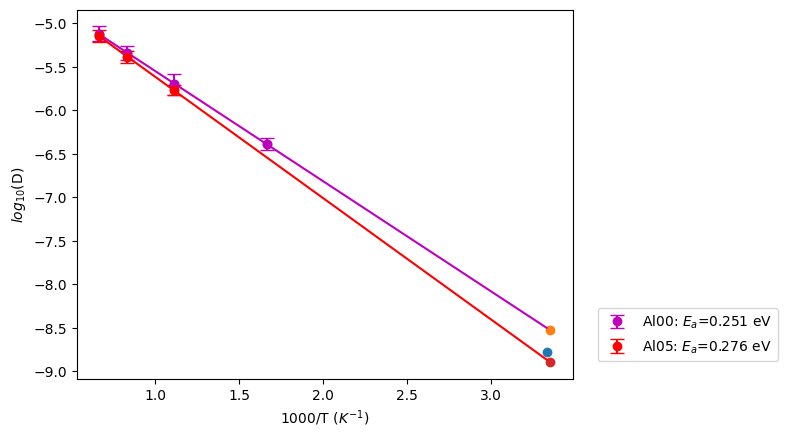

In [22]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

arrhenius_columns = ['Doping Element', 'Doping Concentration (Formulaic)', 
           'Activation Energy (eV)', 'RT D Pred (cm2/s)', 'RT D True (cm2/s)', 'Average Correlation']
arrhenius_df = pd.DataFrame(columns=arrhenius_columns)

arrhenius_config_columns = ['Doping Element', 'Doping Concentration (Formulaic)', 'Configuration',
           'Activation Energy (eV)', 'RT D Pred (cm2/s)', 'RT D True (cm2/s)', 'Average Correlation']
arrhenius_config_df = pd.DataFrame(columns=arrhenius_columns)

# Arrenhius method
def arrhenius(dataframe, plot=False):
    T_groups = dataframe.groupby(['Temperature (K)']).groups
    D_mean = []
    D_std = []
    T = []
    for T_key in T_groups:
        T_group = T_groups[T_key]
        T_group_diffusivity = dataframe.iloc[T_group].reset_index()

        DT_mean = np.mean(T_group_diffusivity['Diffusivity (cm^2/s)'])
        DT_std = np.std(T_group_diffusivity['Diffusivity (cm^2/s)'])
        D_mean.append(DT_mean)
        D_std.append(DT_std)
        T.append(T_key)
    
    D_mean = np.array(D_mean)
    D_RT = np.nan
    for i,t in enumerate(T):
        if t==300:
            D_RT = D_mean[i]
    D_std = np.array(D_std)
    T = np.array(T)
    if plot:
        plt.scatter(1000/T, np.log10(D_mean.astype('float32')))

    # Don't fit to 300K
    filter = T!=300
    T = T[filter]
    D_mean = D_mean[filter]
    D_std = D_std[filter]
    corr_mean = np.mean(dataframe['Correlation Factor'])

    x = 1./T
    y = np.log10(D_mean.astype('float32'))
    weights = D_std / D_mean

    model = LinearRegression()
    model.fit(x.reshape(-1,1), y, weights)
    E_a = E_a_func(model.coef_[0])
    
    D_0 = 10**model.intercept_
    D_RT_pred = D_0 * np.exp(-E_a / (8.62*10**-5 * 298))
    x_prime = np.linspace(np.min(x), 1/300, 100).reshape(-1,1)

    if plot:
        plt.errorbar(1000*x, y, yerr=weights, fmt='o', capsize=5, 
                    label=r'%s%02.f: $E_a$=%.3f eV' % (key[0], 100*key[1], E_a), c=colors[i%(len(colors)-1)])
        plt.plot(1000*x_prime, model.predict(x_prime), c=colors[i%(len(colors)-1)])
        plt.scatter(1000/298, np.log10(D_RT_pred))

    entry = pd.DataFrame([[key[0], key[1], E_a, D_RT_pred, D_RT, corr_mean]], columns=arrhenius_columns)
    return entry

# Arrhenius without configuration information
groups = diffusivity_df.groupby(['Doping Element', 'Doping Concentration (Formulaic)']).groups
for i,key in enumerate(groups):
    group = groups[key]
    group_diffusivity = diffusivity_df.iloc[group].reset_index()
    
    entry = arrhenius(group_diffusivity)
    arrhenius_df = pd.concat([arrhenius_df, entry], ignore_index=True)
display(arrhenius_df)

# Arrhenius WITH configuration information
groups = diffusivity_df.groupby(['Doping Element', 'Doping Concentration (Formulaic)', 'Configuration']).groups
for i,key in enumerate(groups):
    group = groups[key]
    group_diffusivity = diffusivity_df.iloc[group].reset_index()
    plot = True if (i==0 or i==4) else False
    entry = arrhenius(group_diffusivity, plot)
    arrhenius_config_df = pd.concat([arrhenius_config_df, entry], ignore_index=True)
display(arrhenius_config_df)

plt.legend(loc=(1.05, 0.05))
plt.xlabel(r'1000/T ($K^{-1}$)')
plt.ylabel(r'$log_{10}$(D)')
plt.show()

# # Experimental Data
# exp_diffusivity = pd.DataFrame([['Al', 0, None, 291, None, 0.337, None, None, None, None, None],
#                                 ['Al', 0, None, 298, None, 0.467, None, None, None, None, None], 
#                                 ['Al', 0, None, 323, None, 1.190, None, None, None, None, None], 
#                                ], columns=columns) 
# x = 1000./exp_diffusivity['Temperature (K)']
# y = np.log10(exp_diffusivity['Conductivity (mS/cm)'] * exp_diffusivity['Temperature (K)'])
# plt.scatter(x, y,
#             label=r'%s: $E_a$=%.3f eV, DOI: 10.1002/anie.200701144' % ('Exp Al00', 0.30),
#             marker = 'x'
#            )

# exp_diffusivity = pd.DataFrame([['Al', 0.2, None, 1000/2.68, None, 3.533, None, None, None, None, None],
#                                 ['Al', 0.2, None, 1000/2.88, None, 1.735, None, None, None, None, None],
#                                 ['Al', 0.2, None, 1000/3.10, None, 0.751, None, None, None, None, None],
#                                 ['Al', 0.2, None, 1000/3.36, None, 0.293, None, None, None, None, None],
#                                 ['Al', 0.2, None, 1000/3.67, None, 0.084, None, None, None, None, None],
#                                 ['Al', 0.2, None, 1000/3.80, None, 0.045, None, None, None, None, None],
#                                 ['Al', 0.2, None, 1000/3.95, None, 0.024, None, None, None, None, None],
#                                ], columns=columns) 
# x = 1000./exp_diffusivity['Temperature (K)']
# y = np.log10(exp_diffusivity['Conductivity (mS/cm)'] * exp_diffusivity['Temperature (K)'])
# plt.scatter(x, y,
#             label=r'%s: $E_a$=%.3f eV,  DOI: 10.1038/srep18053' % ('Exp Al20', 0.36),
#             marker = 'x'
#            )

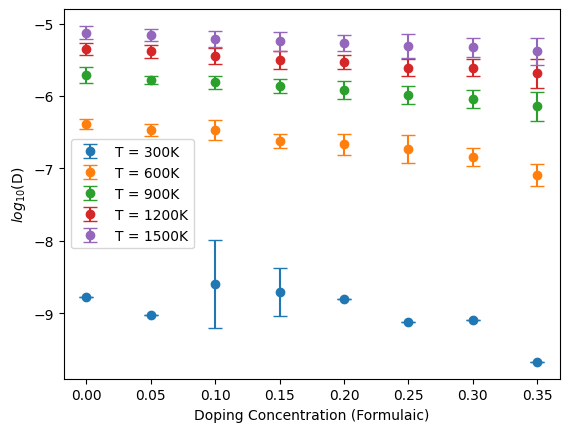

In [23]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

conc_summary_columns = ['Doping Concentration (Formulaic)', 'Temperature (K)', 
                        'Mean Diffusivity (cm^2/s)', 'STD Diffusivity (cm^2/s)']
conc_summary = pd.DataFrame(columns=conc_summary_columns)

diffusivity_df = diffusivity_df.reset_index()
groups = diffusivity_df.groupby(['Temperature (K)']).groups
for i,key in enumerate(groups):
    group = groups[key]
    group_diffusivity = diffusivity_df.iloc[group].reset_index()
    group_diffusivity = group_diffusivity.drop(columns=['level_0'])

    conc_groups = group_diffusivity.groupby(['Doping Concentration (Formulaic)']).groups
    for conc_i,conc_key in enumerate(conc_groups):
        conc_group = conc_groups[conc_key]
        conc_group_diffusivity = group_diffusivity.iloc[conc_group].reset_index()

        entry = pd.DataFrame([[conc_key, key, np.mean(conc_group_diffusivity['Diffusivity (cm^2/s)']), np.std(conc_group_diffusivity['Diffusivity (cm^2/s)'])]], columns=conc_summary_columns)
        conc_summary = pd.concat([conc_summary, entry], ignore_index=True)

groups = conc_summary.groupby(['Temperature (K)']).groups
for i,key in enumerate(groups):
    group = groups[key]
    data = conc_summary.iloc[group].reset_index()

    x = data['Doping Concentration (Formulaic)']
    y = np.log10(data['Mean Diffusivity (cm^2/s)']).astype('float32')
    weights = data['STD Diffusivity (cm^2/s)'] / data['Mean Diffusivity (cm^2/s)']

    plt.errorbar(x, y, yerr=weights, fmt='o', capsize=5, label=r'T = %0.fK' % (key))

plt.legend()
plt.xlabel("Doping Concentration (Formulaic)")
plt.ylabel(r'$log_{10}$(D)')
plt.show()

,Doping Element,Doping Concentration (Formulaic),Mean Activation Energy (eV),STD Activation Energy (eV),Mean RT D Pred (cm2/s),STD RT D Pred (cm2/s),Mean RT D True (cm2/s),STD RT D True (cm2/s),Average Correlation
0,Al,0.00,0.257287,0.005911,2.455615e-09,4.261510e-10,1.675586e-09,0.0,3.084355
1,Al,0.05,0.265130,0.007987,1.813330e-09,3.915332e-10,9.437991e-10,0.0,3.050735
2,Al,0.10,0.258877,0.012705,1.994320e-09,7.491406e-10,2.520001e-09,0.0,3.034314
3,Al,0.15,0.275690,0.007899,1.044999e-09,2.332392e-10,1.973090e-09,0.0,3.021642
4,Al,0.20,0.284605,0.005439,7.449403e-10,1.344608e-10,1.593012e-09,0.0,3.058730
5,Al,0.25,0.285531,0.011563,6.622677e-10,2.043673e-10,7.592875e-10,0.0,3.021694
6,Al,0.30,0.300946,0.002751,3.791418e-10,4.462105e-11,7.969923e-10,0.0,3.090389
7,Al,0.35,0.326475,0.008875,1.587678e-10,5.280993e-11,2.136333e-10,0.0,3.187982


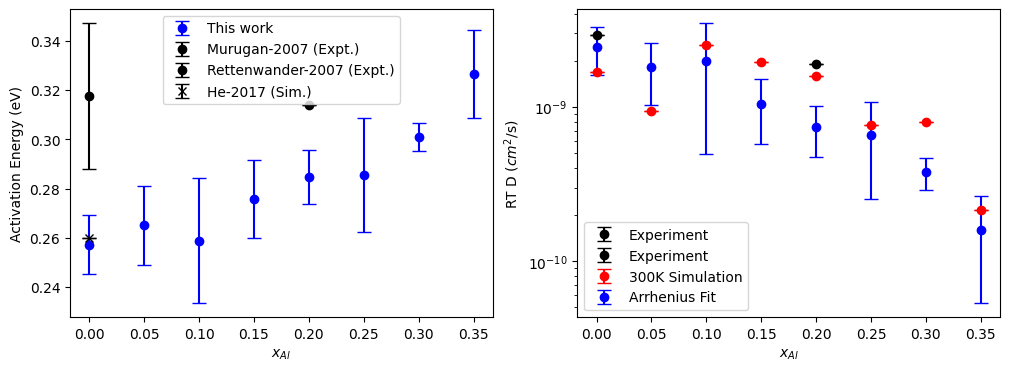

In [24]:
fig, axs = plt.subplots(1,2, figsize=(12,4))

groups = arrhenius_config_df.groupby(['Doping Element', 'Doping Concentration (Formulaic)']).groups
reduced_summary_columns = ['Doping Element', 'Doping Concentration (Formulaic)', 
           'Mean Activation Energy (eV)', 'STD Activation Energy (eV)',
           'Mean RT D Pred (cm2/s)', 'STD RT D Pred (cm2/s)',
           'Mean RT D True (cm2/s)', 'STD RT D True (cm2/s)', 'Average Correlation']
reduced_arrhenius = pd.DataFrame(columns=reduced_summary_columns)
for key in groups:
    group = groups[key]
    group_arrhenius = arrhenius_config_df.iloc[group].reset_index()

    D_pred_ave = np.mean(group_arrhenius['RT D Pred (cm2/s)'])
    D_pred_std = np.std(group_arrhenius['RT D Pred (cm2/s)'])
    D_true_ave = np.mean(group_arrhenius['RT D True (cm2/s)'])
    D_true_std = np.std(group_arrhenius['RT D True (cm2/s)'])
    Ea_ave = np.mean(group_arrhenius['Activation Energy (eV)'])
    Ea_std = np.std(group_arrhenius['Activation Energy (eV)'])
    corr = group_arrhenius['Average Correlation']

    entry = pd.DataFrame([[key[0], key[1], Ea_ave, Ea_std, D_pred_ave, D_pred_std, D_true_ave, D_true_std, np.mean(corr)]], columns=reduced_summary_columns)
    reduced_arrhenius = pd.concat([reduced_arrhenius, entry], ignore_index=True)

filter = reduced_arrhenius['Doping Concentration (Formulaic)'] <= 0.36
reduced_arrhenius = reduced_arrhenius[filter]
display(reduced_arrhenius)

axs[0].errorbar(reduced_arrhenius['Doping Concentration (Formulaic)'], 
                reduced_arrhenius['Mean Activation Energy (eV)'], 
                yerr=2*reduced_arrhenius['STD Activation Energy (eV)'], c='blue', fmt='o', capsize=5, label='This work')

murugan = [0.30, 0.31, 0.32, 0.34] 
axs[0].errorbar(0, np.mean(murugan),
                yerr=2*np.std(murugan), c='black', fmt='o', capsize=5, label='Murugan-2007 (Expt.)')
exp = [0.314] 
axs[0].errorbar(0.2, np.mean(exp),
                yerr=2*np.std(exp), c='black', fmt='o', capsize=5, label='Rettenwander-2007 (Expt.)')

# murugan
exp = [2.94e-9]
axs[1].errorbar(0, np.mean(exp),
                yerr=2*np.std(exp), c='black', fmt='o', capsize=5, label='Experiment')
# li
exp = [1.9e-9] 
axs[1].errorbar(0.2, np.mean(exp),
                yerr=2*np.std(exp), c='black', fmt='o', capsize=5, label='Experiment')

he = [0.26]
axs[0].errorbar(0, np.mean(he),
                yerr=2*np.std(he), c='black', fmt='x', capsize=5, label='He-2017 (Sim.)')

axs[1].errorbar(reduced_arrhenius['Doping Concentration (Formulaic)'], 
                reduced_arrhenius['Mean RT D True (cm2/s)'], 
                yerr=2*reduced_arrhenius['STD RT D True (cm2/s)'], c='red', fmt='o', capsize=5, label='300K Simulation')

axs[1].errorbar(reduced_arrhenius['Doping Concentration (Formulaic)'], 
                reduced_arrhenius['Mean RT D Pred (cm2/s)'], 
                yerr=2*reduced_arrhenius['STD RT D Pred (cm2/s)'], c='blue', fmt='o', capsize=5, label='Arrhenius Fit')

axs[0].set_xlabel(r'$x_{Al}$')
axs[0].set_ylabel('Activation Energy (eV)')
axs[1].set_xlabel(r'$x_{Al}$')
axs[1].set_ylabel(r'RT D ($cm^{2}$/s)')
axs[1].set_yscale('log')
axs[0].legend()
axs[1].legend()
plt.show()